In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl # with 8 million rows using a faster DataFrame library than pandas can be helpfull


In [2]:
pldf=pl.read_parquet('cleaned_births_14_15.parquet')

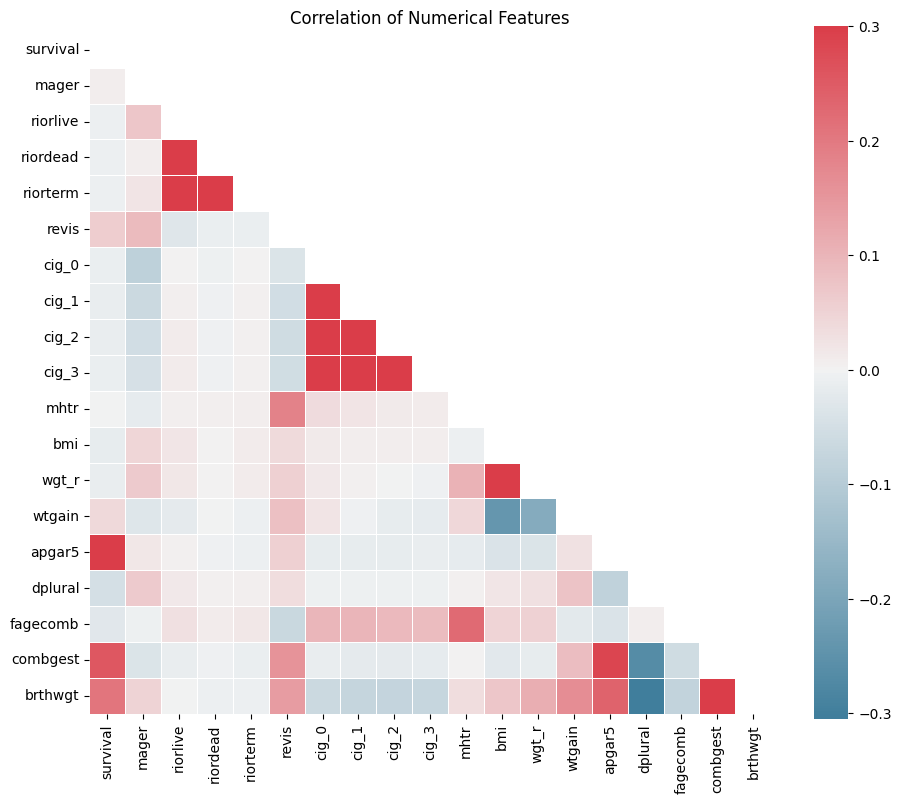

In [44]:
df=pldf.to_pandas()
corr = df.select_dtypes(include=np.number).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5)
plt.title('Correlation of Numerical Features')
plt.show()
del df

In [157]:
infant_mortality14_15=(1-pldf.select(pl.col('survival')).mean().to_pandas().values[0][0])*1000
print('The infant mortality rate for 2014 and 2015 combined was {} deaths per 1000 births.'.format(infant_mortality14_15))

The infant mortality rate for 2014 and 2015 combined was 5.840933687980332 deaths per 1000 births.


### Infant mortality rates segmented by race of mother.

One of the more tragic and historically constant trends in United States infant mortality is the variation between racial groups. It is demonstrated below that the infant mortality rates of infants born to black mothers are more than twice as likely to die before their first birthday than infants born to white or asain mothers. 

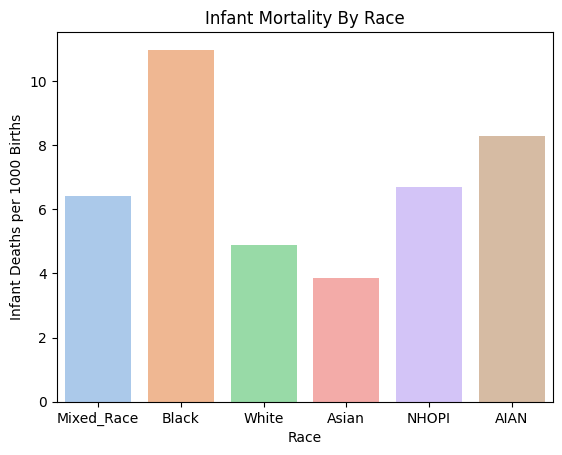

In [123]:
by_race=pldf.groupby(pl.col('mrace6')).agg(pl.col('survival').mean()).to_pandas()
by_race.survival=(1-by_race.survival)*1000
sns.set_palette("pastel")
sns.barplot(by_race[by_race.mrace6!="NA"],y='survival',x='mrace6')
plt.xlabel('Race')
plt.ylabel('Infant Deaths per 1000 Births')
plt.title("Infant Mortality By Race")
plt.show()

### Infant mortality by mother's education.

It is not entirely suprising that infant mortality rates are roughly inversely proportional to the mother's level of education. This is shown below. It is worth mentioning the small anomally of mothers with less than an eigth grade education having a lower infant mortality rate than some-college, high school, and high school with no diploma. Suprisingly this is not caused by mothers with less than an eighth grade education being younger, as the mean age of a mother with less than an eight grade education is 29.46 while high school is 26.08, some-college is 27.44, and highschool without a diploma is 24.69.

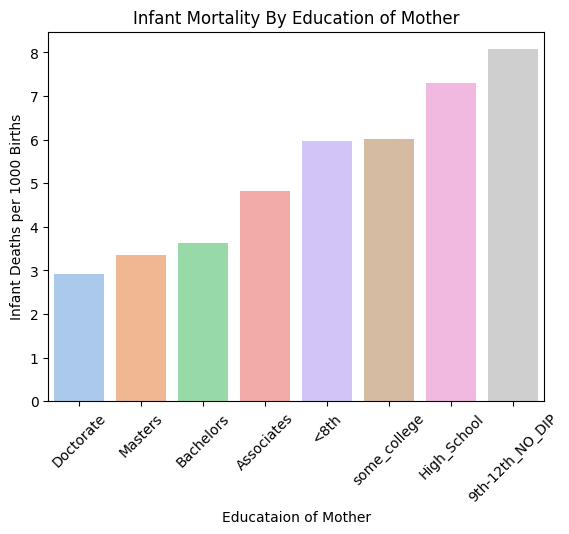

In [135]:
meduc_order=['Doctorate','Masters','Bachelors','Associates','<8th','some_college','High_School','9th-12th_NO_DIP']
by_meduc=pldf.groupby('meduc').agg(pl.col('survival').mean()).to_pandas()
by_meduc.survival=(1-by_meduc.survival)*1000
sns.set_palette("pastel")
sns.barplot(by_meduc[by_meduc.meduc!='Unknown'],y='survival',x='meduc',order=meduc_order)
plt.xticks(rotation=45)
plt.xlabel('Educataion of Mother')
plt.ylabel('Infant Deaths per 1000 Births')
plt.title("Infant Mortality By Education of Mother")
plt.show()

### Total number of births per weekday.

While this is certainly not a ground-braking demographic trend, it is interesting that considerably fewer births occur on weekends when hospitals have fewer resources. While it is common to think of giving birth as a spontaneous process that can not be delayed the following plot shows that births, atleast in part, are constrained by the five day work week.

Text(0, 0.5, 'Quantity of Births')

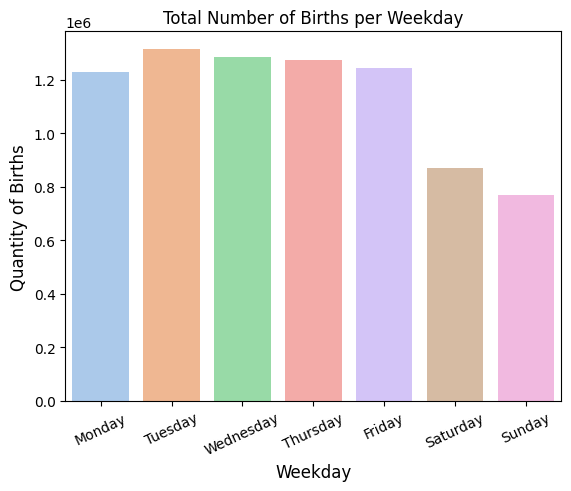

In [137]:
birth_freq_wk=pldf.select(pl.col('dob_wk')).to_pandas().value_counts()

birth_freq_wk=birth_freq_wk.reset_index()
birth_freq_wk.columns=['dob_wk','total_births']
sns.set_palette("pastel")
sns.barplot(birth_freq_wk,x='dob_wk',y='total_births',order=['Monday','Tuesday','Wednesday',
                                                                               'Thursday','Friday',
                                                                               'Saturday','Sunday'])
plt.title('Total Number of Births per Weekday')
plt.xlabel('Weekday',fontsize = 12)
plt.xticks(rotation=25)
plt.ylabel('Quantity of Births',fontsize = 12)

### Balanced Data For Visualizations

As there are almost 8million rows in  this data set it is usefull to take a balanced subset of the data for visualizations. This allows for a much easier comparison of trends between infant deaths and surivals. Below a balanced data set for visualizations is constructed by keeping all 46 thousand infant deaths and randomly sampling an additional 46 thousand births.

In [138]:

balanced_births=pd.concat([pldf.filter(pl.col('survival')<1).to_pandas(),
           pldf.filter(pl.col('survival')>0).to_pandas().sample(46651)],axis=0)

           

### Birth weight segmented by survival of the infant.

This very clearly demonstrates the massive predictive power that birth weight has in predicting infant mortality. It should be noted that birth weights under 227 grams are recorded as 227 grams which is why there is such a sharp decline at that value. Additionally it is worth noting the gaussian shaped set of birth weights associated with infant deaths that are closer in value to the mean birthweight of infants that survived. This trend demonstrated one of the difficulties in modeling infant mortality, that one portion of infant deaths occur rapidly after birth while another portion occur anytime before the infant's first birthday.

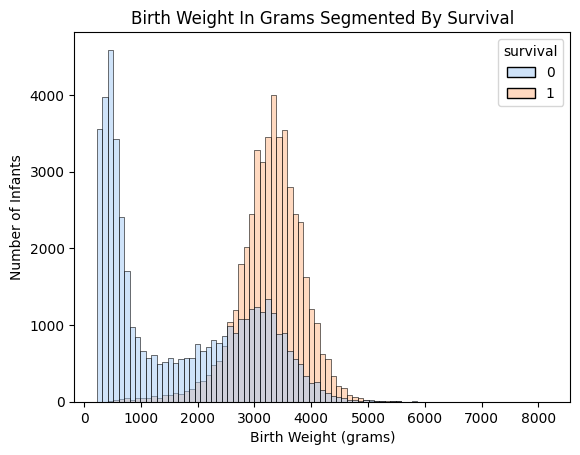

In [141]:

sns.histplot(balanced_births,x='brthwgt',hue='survival')
plt.title("Birth Weight In Grams Segmented By Survival")
plt.xlabel('Birth Weight (grams)')
plt.ylabel('Number of Infants')
plt.show()



### Number of prenatal visits, segmented by infant mortality.

While not as concise as the above plot, the below plot further illustrates a seperable trend in infant death and survival data. The mothers of infants that did not survive generally attended fewer pre-natal medical appointments than the mothers of infants that survived. 

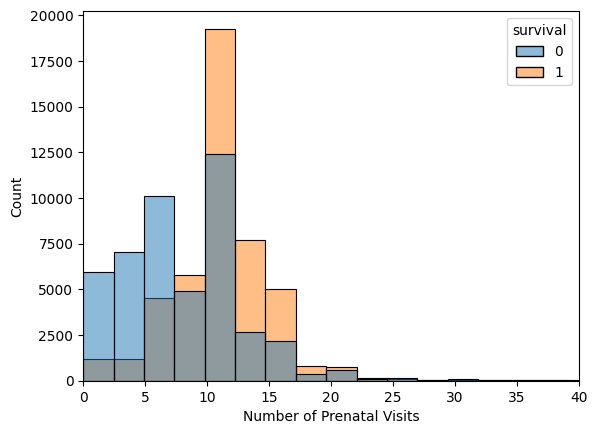

In [68]:
fig, ax = plt.subplots()
sns.histplot(balanced_births,x='revis',hue='survival',bins=40)
plt.xlabel('Number of Prenatal Visits')
ax.set_xlim(0,40)
plt.show()

### Period of gestation in weeks serves as a powerfull metric for prediction of infant mortality in much the same way that birth weight does.

The below plot is similar to the plot of birth weight in its demonstration of the existence of two subsets of infant deaths, those with abnormal vital signs at birth which largely perish shortly after being born and those with more normal medical characteristics that perish at some point before their first birthday.



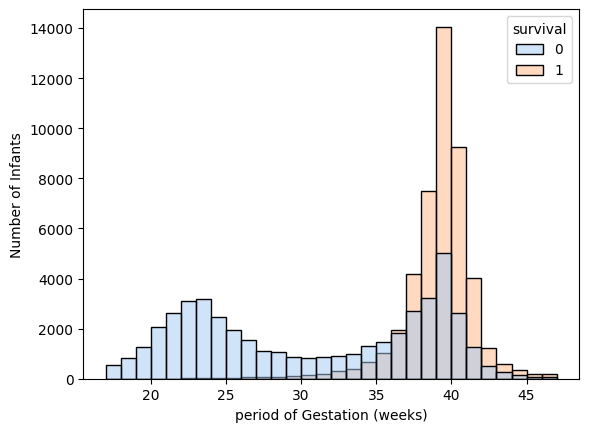

In [145]:
sns.histplot(balanced_births,x='combgest',hue='survival',bins=30)
plt.xlabel('period of Gestation (weeks)')
plt.ylabel('Number of Infants')
plt.show()

### The five minute apgar score proves to be one of the if not the most powerfull predictor of infant mortality.

The somewhat underwheliming plot below does not provide striking visual evidence for this fact, however it can be seen that infants that died have apgar scores that range from 0 to 10 while infants that survived are very tightly clustered at an apgar score of 9 or 10. Again, we see a slightly bimodal distribution of healthy and unhealthy apgar scores for infants that ultimately perished.

The apgar score proves to be such a powerfull predictor of infant mortality because it is essentially a metric of how well an five minute old infant is doing outside of its mother's womb. A low score indicates that the infants vitals signs are in abnormally poor condition while a high score indicates that the infant's vital signs are normal.

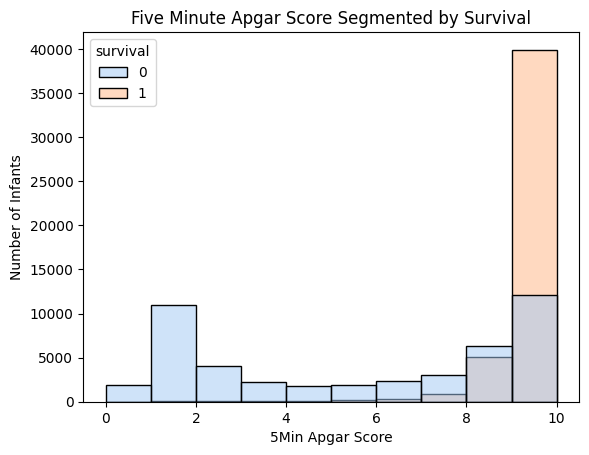

In [156]:

sns.histplot(balanced_births,x='apgar5',hue='survival',bins=10)
plt.title("Five Minute Apgar Score Segmented by Survival")
plt.xlabel('5Min Apgar Score')
plt.ylabel('Number of Infants')
plt.show()



### Somewhat suprisingly there does not exist a clear relationship between infant mortality and age of the mother.

As is evident below the age distribution of mothers of infants that survived and those that died is indistinguishable.

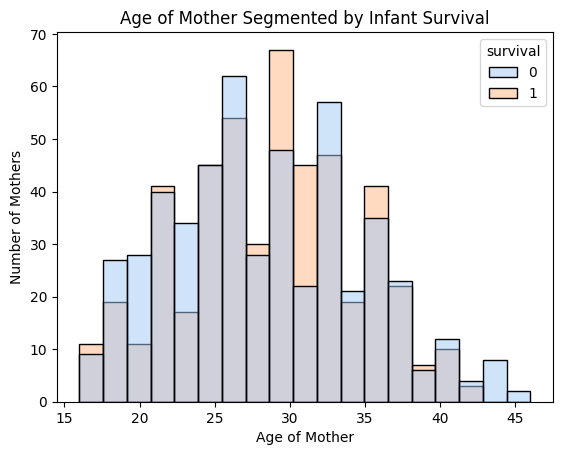

In [155]:
sns.histplot(balanced_births.sample(1000),x='mager',hue='survival')
plt.title("Age of Mother Segmented by Infant Survival")
plt.xlabel('Age of Mother')
plt.ylabel('Number of Mothers')
plt.show()